In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from sklearn import preprocessing

import os
import time
import copy
from tqdm.notebook import trange, tqdm

In [2]:
path = '../input/animal-image-dataset-90-different-animals'

with open(path + "/name of the animals.txt") as f:
    classes = f.read().split('\n')

# View classes
num_classes = len(classes)
print(f'Number of classes: {num_classes}')
print(f'Classes of animals: {", ".join(classes)}')

Number of classes: 90
Classes of animals: antelope, badger, bat, bear, bee, beetle, bison, boar, butterfly, cat, caterpillar, chimpanzee, cockroach, cow, coyote, crab, crow, deer, dog, dolphin, donkey, dragonfly, duck, eagle, elephant, flamingo, fly, fox, goat, goldfish, goose, gorilla, grasshopper, hamster, hare, hedgehog, hippopotamus, hornbill, horse, hummingbird, hyena, jellyfish, kangaroo, koala, ladybugs, leopard, lion, lizard, lobster, mosquito, moth, mouse, octopus, okapi, orangutan, otter, owl, ox, oyster, panda, parrot, pelecaniformes, penguin, pig, pigeon, porcupine, possum, raccoon, rat, reindeer, rhinoceros, sandpiper, seahorse, seal, shark, sheep, snake, sparrow, squid, squirrel, starfish, swan, tiger, turkey, turtle, whale, wolf, wombat, woodpecker, zebra


In [3]:
animal_path = path + "/animals/animals"

# See the number of images for each class
for animal in os.listdir(animal_path):
    print(f'Number of {animal} images: {len(os.listdir(animal_path + "/" + animal))}')

Number of beetle images: 60
Number of parrot images: 60
Number of fox images: 60
Number of wolf images: 60
Number of hedgehog images: 60
Number of turtle images: 60
Number of snake images: 60
Number of shark images: 60
Number of horse images: 60
Number of antelope images: 60
Number of hamster images: 60
Number of woodpecker images: 60
Number of eagle images: 60
Number of chimpanzee images: 60
Number of bison images: 60
Number of penguin images: 60
Number of butterfly images: 60
Number of sandpiper images: 60
Number of hornbill images: 60
Number of lion images: 60
Number of lobster images: 60
Number of oyster images: 60
Number of otter images: 60
Number of grasshopper images: 60
Number of raccoon images: 60
Number of dog images: 60
Number of pigeon images: 60
Number of donkey images: 60
Number of hippopotamus images: 60
Number of hummingbird images: 60
Number of bear images: 60
Number of coyote images: 60
Number of bee images: 60
Number of pig images: 60
Number of rat images: 60
Number 

### Split data 

In [10]:
def shuffle_data(X, seed):
    if seed:
        np.random.seed(seed)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    
    return np.array(X)[idx]
    
    
def data_split(animal_path, split_size=0.1):
    """
        Based on split size, 
        Each folder is split into training and test sets.

        Returns:
            Shuffled training, validation and test dataset
            Each set is in the form of: ['id.jpg', 'string label of id']
                Example: [['1234.jpg', 'antelope'], ['12312.jpg', 'iguana'] ...]
    """
    
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    # For each label
    for animal in os.listdir(animal_path):
        
        # Extract same label for training, validation, test data
        label = animal
        
        # Image path for each animal
        image_list = os.listdir(animal_path + "/" + animal)
        
        # Shuffle images (path) 
        shuffled_data = shuffle_data(image_list, seed=None)
        
        # Get the train, val, test split
        split_i = len(shuffled_data) - int(len(shuffled_data) // (1 / (split_size * 2)))
        split_j = len(shuffled_data) - int(len(shuffled_data) // (1 / split_size)) 
        
        # Get training data from train_val_data split[:split_j]
        train_data = shuffled_data[:split_i]
        
        # Add training data, label to final training data
        X_train.extend(train_data) 
        y_train.extend([label] * len(train_data)) 
        
        # Get val data and label from train_val_data split[split_j:]
        val_data = shuffled_data[split_i:split_j]
        
        # Add val data, label to final val data
        X_val.extend(val_data) 
        y_val.extend([label] * len(val_data)) 
        
        # Get test data from shuffled_data[split_i:]
        test_data = shuffled_data[split_j:]
       
        # Add test data, label to final val data
        X_test.extend(test_data) 
        y_test.extend([label] * len(test_data)) 
    
    
    # Each image is presented as: ['image id.jpg', 'string label']
    training_data = list(zip(X_train, y_train))
    val_data = list(zip(X_val, y_val))
    test_data = list(zip(X_test, y_test))
    
    #Shuffle all data in respective sets
    shuffled_training_data = shuffle_data(training_data, seed=None)
    shuffled_val_data = shuffle_data(val_data, seed=None)
    shuffled_test_data = shuffle_data(test_data, seed=None)
    
    return shuffled_training_data, shuffled_val_data, shuffled_test_data

In [14]:
# Split size for training, validation, test
split_size = 0.08

train_data, val_data, test_data = data_split(animal_path, split_size=split_size)
print('Number of training images: {}'.format(len(train_data)))
print('Number of validation images: {}'.format(len(val_data))) 
print('Number of testing images: {}'.format(len(test_data)))

Number of training images: 4590
Number of validation images: 450
Number of testing images: 360


In [15]:
def image_plot(data):
    fig = plt.figure(figsize=(20, 6))
    rows = 3
    columns = 10

    ax = []

    # See the first 30 images
    for i in range(30):
        image, label = data[i]
        
        ax.append(fig.add_subplot(rows, columns, i+1))
        
        if torch.is_tensor(image):
            image = image.permute(1, 2, 0)
            ax[-1].set_title(le.inverse_transform([label])[0], fontsize=12, fontweight='bold')
        else:
            image_path =  os.path.join(animal_path + "/" + label + "/" + image)
            image = mpimg.imread(image_path)
            ax[-1].set_title(label, fontsize=12, fontweight='bold')
        
        plt.imshow(image)
        plt.axis('off')

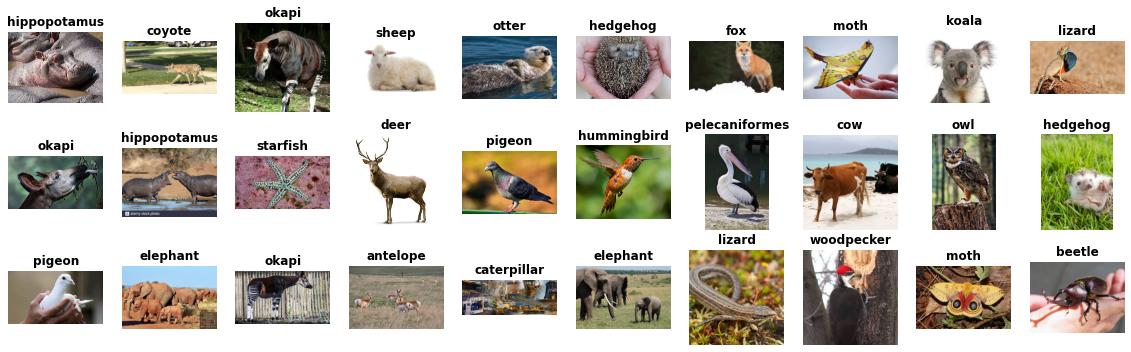

In [16]:
# See some of the training images before pre-processing
image_plot(train_data)

### Dataset preparation and Label Encoding

In [17]:
# To convert string labels into integers
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [18]:
class _Dataset(Dataset):
    
    def __init__(self, data, transform=None):
        data, label = zip(*data)
        
        # Transform string labels into integers
        label = le.transform(label)
        
        self.x = np.array(data)
        self.y = np.array(label)
        self.num_samples = len(data)
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        img_path = os.path.join(animal_path, le.inverse_transform([sample[1]])[0], sample[0])
        img = mpimg.imread(img_path)
        
        if self.transform:
            
            features = self.transform(img)
        
        return features, sample[1]
    
    def __len__(self):
        return self.num_samples
    
data_transforms = {
    'train': transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize(256),
         transforms.RandomCrop(224),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.GaussianBlur(3),
         transforms.ColorJitter(0.5),
         transforms.RandomRotation(15),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [19]:
training_dataset = _Dataset(train_data, transform=data_transforms['train'])
validation_dataset = _Dataset(val_data, transform=data_transforms['val'])
test_dataset = _Dataset(test_data, transform=data_transforms['val'])

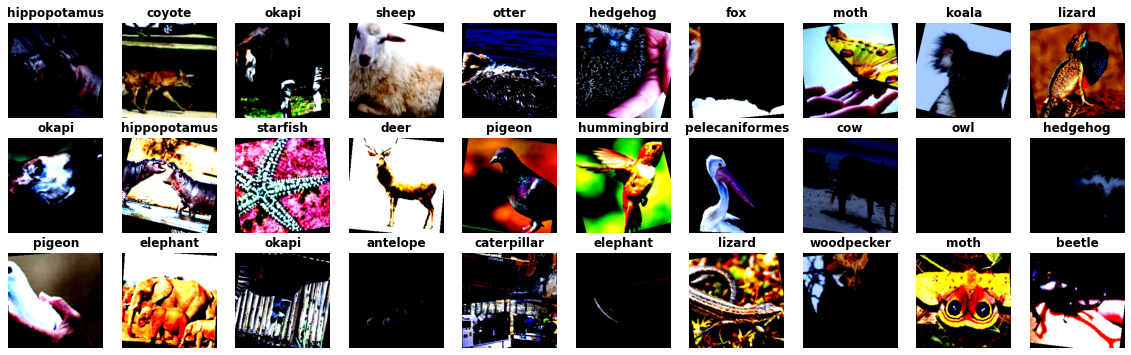

In [20]:
# Visualise augmented ugly images
image_plot(training_dataset)

In [21]:
BATCH_SIZE=32

train_loader = torch.utils.data.DataLoader(dataset=training_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(dataset=validation_dataset, shuffle=False, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

### Model

In [22]:
# Early stopping adapted from: https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
# Slightly modified to reset counter if increasing loss is not across consecutive epochs
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            if self.counter > 0:
                print(f"Early stopping counter resetting from {self.counter} to 0.")
                self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [23]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # Use pre-trained model
        self.model = models.densenet161(pretrained=True)
        
        # Freeze all layers (No training)
        for param in self.parameters():
            param.requires_grad = False
            
        # Change final FC layer to num_classes output. This is trainable by default
        self.model.classifier = nn.Linear(2208, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x
          

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = NeuralNet().to(device)

# Model Summary
print(model)

NeuralNet(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.

In [24]:
# Boilerplate code adapted: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, early_stopping=None):
    since = time.time()
    
    training_accuracies, training_losses, val_accuracies, val_losses = [], [], [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 60)
        
        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
                dataloaders = train_loader
                dataset_sizes = len(training_dataset)
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = val_loader
                dataset_sizes = len(validation_dataset)

            running_loss = 0.0
            running_corrects = 0
     
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            if phase == 'Training':
                training_accuracies.append(epoch_acc)
                training_losses.append(epoch_loss)
            else:
                val_accuracies.append(epoch_acc)
                val_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            
            print('{} Loss after epoch: {:.4f}, Acc after epoch: {:.4f}\n'.format(
            phase, epoch_loss, epoch_acc))
            
        
        # Early stopping check with last average validation loss after end of epoch
        if early_stopping is not None:
            early_stopping(val_losses[-1])

            if early_stopping.early_stop:
                print('Early Stopping Initiated')
                break


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_accuracies, training_losses, val_accuracies, val_losses   

learning_rate=0.01

num_epochs=100

criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.Adam(model.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

# Early stopping if val_loss does not improve from the best - 1e-5 over next 5 epochs
es = EarlyStopping(patience=5, min_delta=1e-5)

In [25]:
model_ft, training_accuracies, training_losses, val_accuracies, val_losses = train_model(model=model,
                                                                                         train_loader= train_loader,
                                                                                         val_loader=val_loader, 
                                                                                         criterion=criterion, 
                                                                                         optimizer=optimizer_ft, 
                                                                                         num_epochs=num_epochs, 
                                                                                         scheduler=exp_lr_scheduler, 
                                                                                         early_stopping=es)

Epoch 1/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 2.5659, Acc after epoch: 0.5566



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.8926, Acc after epoch: 0.7822

Epoch 2/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.9420, Acc after epoch: 0.7819



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.8202, Acc after epoch: 0.8267

Epoch 3/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.9319, Acc after epoch: 0.8159



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.7944, Acc after epoch: 0.8422

Epoch 4/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.8947, Acc after epoch: 0.8294



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.8864, Acc after epoch: 0.8444

Early stopping counter 1 of 5
Epoch 5/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.8424, Acc after epoch: 0.8423



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.8159, Acc after epoch: 0.8600

Early stopping counter 2 of 5
Epoch 6/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.7630, Acc after epoch: 0.8617



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.9555, Acc after epoch: 0.8444

Early stopping counter 3 of 5
Epoch 7/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.7174, Acc after epoch: 0.8699



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.6115, Acc after epoch: 0.8956

Early stopping counter resetting from 3 to 0.
Epoch 8/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.6048, Acc after epoch: 0.8924



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.7849, Acc after epoch: 0.8867

Early stopping counter 1 of 5
Epoch 9/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.6709, Acc after epoch: 0.8871



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.8830, Acc after epoch: 0.8578

Early stopping counter 2 of 5
Epoch 10/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.6763, Acc after epoch: 0.8950



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 1.0919, Acc after epoch: 0.8444

Early stopping counter 3 of 5
Epoch 11/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.3059, Acc after epoch: 0.9442



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4594, Acc after epoch: 0.9178

Early stopping counter resetting from 3 to 0.
Epoch 12/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1598, Acc after epoch: 0.9636



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4583, Acc after epoch: 0.9222

Epoch 13/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1727, Acc after epoch: 0.9614



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4623, Acc after epoch: 0.9244

Early stopping counter 1 of 5
Epoch 14/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1548, Acc after epoch: 0.9673



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4481, Acc after epoch: 0.9267

Early stopping counter resetting from 1 to 0.
Epoch 15/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1616, Acc after epoch: 0.9630



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4590, Acc after epoch: 0.9267

Early stopping counter 1 of 5
Epoch 16/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1691, Acc after epoch: 0.9634



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4569, Acc after epoch: 0.9289

Early stopping counter 2 of 5
Epoch 17/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1806, Acc after epoch: 0.9643



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4569, Acc after epoch: 0.9244

Early stopping counter 3 of 5
Epoch 18/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1662, Acc after epoch: 0.9664



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4808, Acc after epoch: 0.9333

Early stopping counter 4 of 5
Epoch 19/100
------------------------------------------------------------


  0%|          | 0/144 [00:00<?, ?it/s]

Training Loss after epoch: 0.1590, Acc after epoch: 0.9627



  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss after epoch: 0.4856, Acc after epoch: 0.9289

Early stopping counter 5 of 5
Early Stopping Initiated
Training complete in 46m 37s
Best val Acc: 0.933333


### Training and Validation Plots

In [26]:
# Plots for accuracy and loss
def plot_history():
    with plt.style.context('seaborn-darkgrid'):
        fig = plt.figure(figsize=(25,10))

        # Summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot([*range(len(training_accuracies))], training_accuracies)
        plt.plot([*range(len(val_accuracies))], val_accuracies)
        plt.title('Accuracy ', fontsize=15)
        plt.ylabel('Accuracy', fontsize=15)
        plt.xlabel('Epoch', fontsize=15)
    #     plt.ylim([0.4, 1.0])
        plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right', fontsize=15)

        # Summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot([*range(len(training_losses))], training_losses, label='training loss')
        plt.plot([*range(len(val_losses))], val_losses, label='validation loss')
        plt.title('Losses', fontsize=15)
        plt.ylabel('Loss', fontsize=15)
        plt.xlabel('Epoch', fontsize=15)
    #     plt.ylim([0.0, 1.5])
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper right', fontsize=15)

        plt.show()


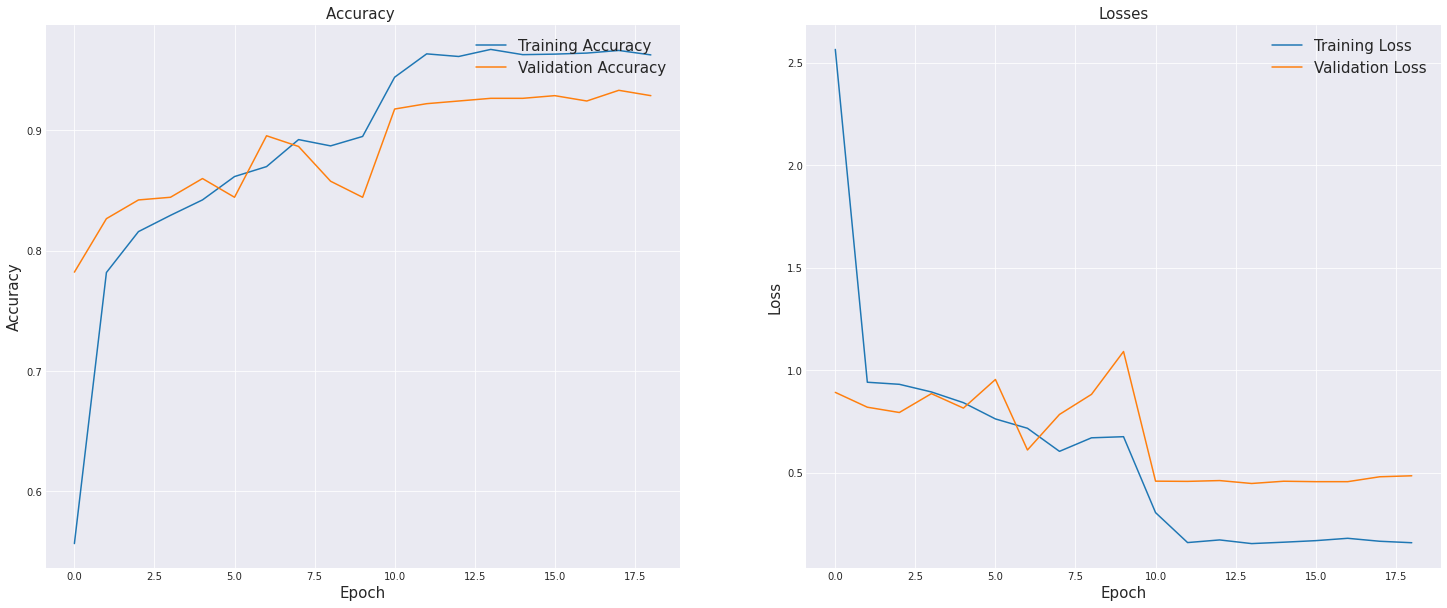

In [27]:
plot_history()

### Visualise model predictions

In [33]:
def visualize_model(model, data_loader, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25, 30))
    
    fig.canvas.draw()
    
    rows = 5
    columns = 5
    
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])
    
    with torch.no_grad():
            
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            val, preds = torch.max(outputs, 1)

            preds_invtrans = le.inverse_transform(preds.cpu())
            
            labels_invtrans = le.inverse_transform(labels.cpu())
            
            ax = []
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax.append(plt.subplot(rows, columns, images_so_far))

                # Reverse normalize 
                image = inputs.cpu().data[j] * STD[:, None, None] + MEAN[:, None, None]

                image = image.permute(1, 2, 0)

                ax[-1].set_title(f'Ground Truth: {labels_invtrans[j]}\nPredicted: {preds_invtrans[j]}', fontsize=15, fontweight='bold')
                
                # Draw boxes around subplots
                bbox = ax[-1].get_tightbbox(fig.canvas.renderer)
                x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
                
                # slightly increase the very tight bounds:
                xpad = 0.01 * width
                ypad = 0.01 * height
                
                if preds[j] == labels[j]:
                     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='green', linewidth=5, fill=False))
                else:
                     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='red', linewidth=5, fill=False))

                plt.imshow(image)
                plt.axis('off')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)
        

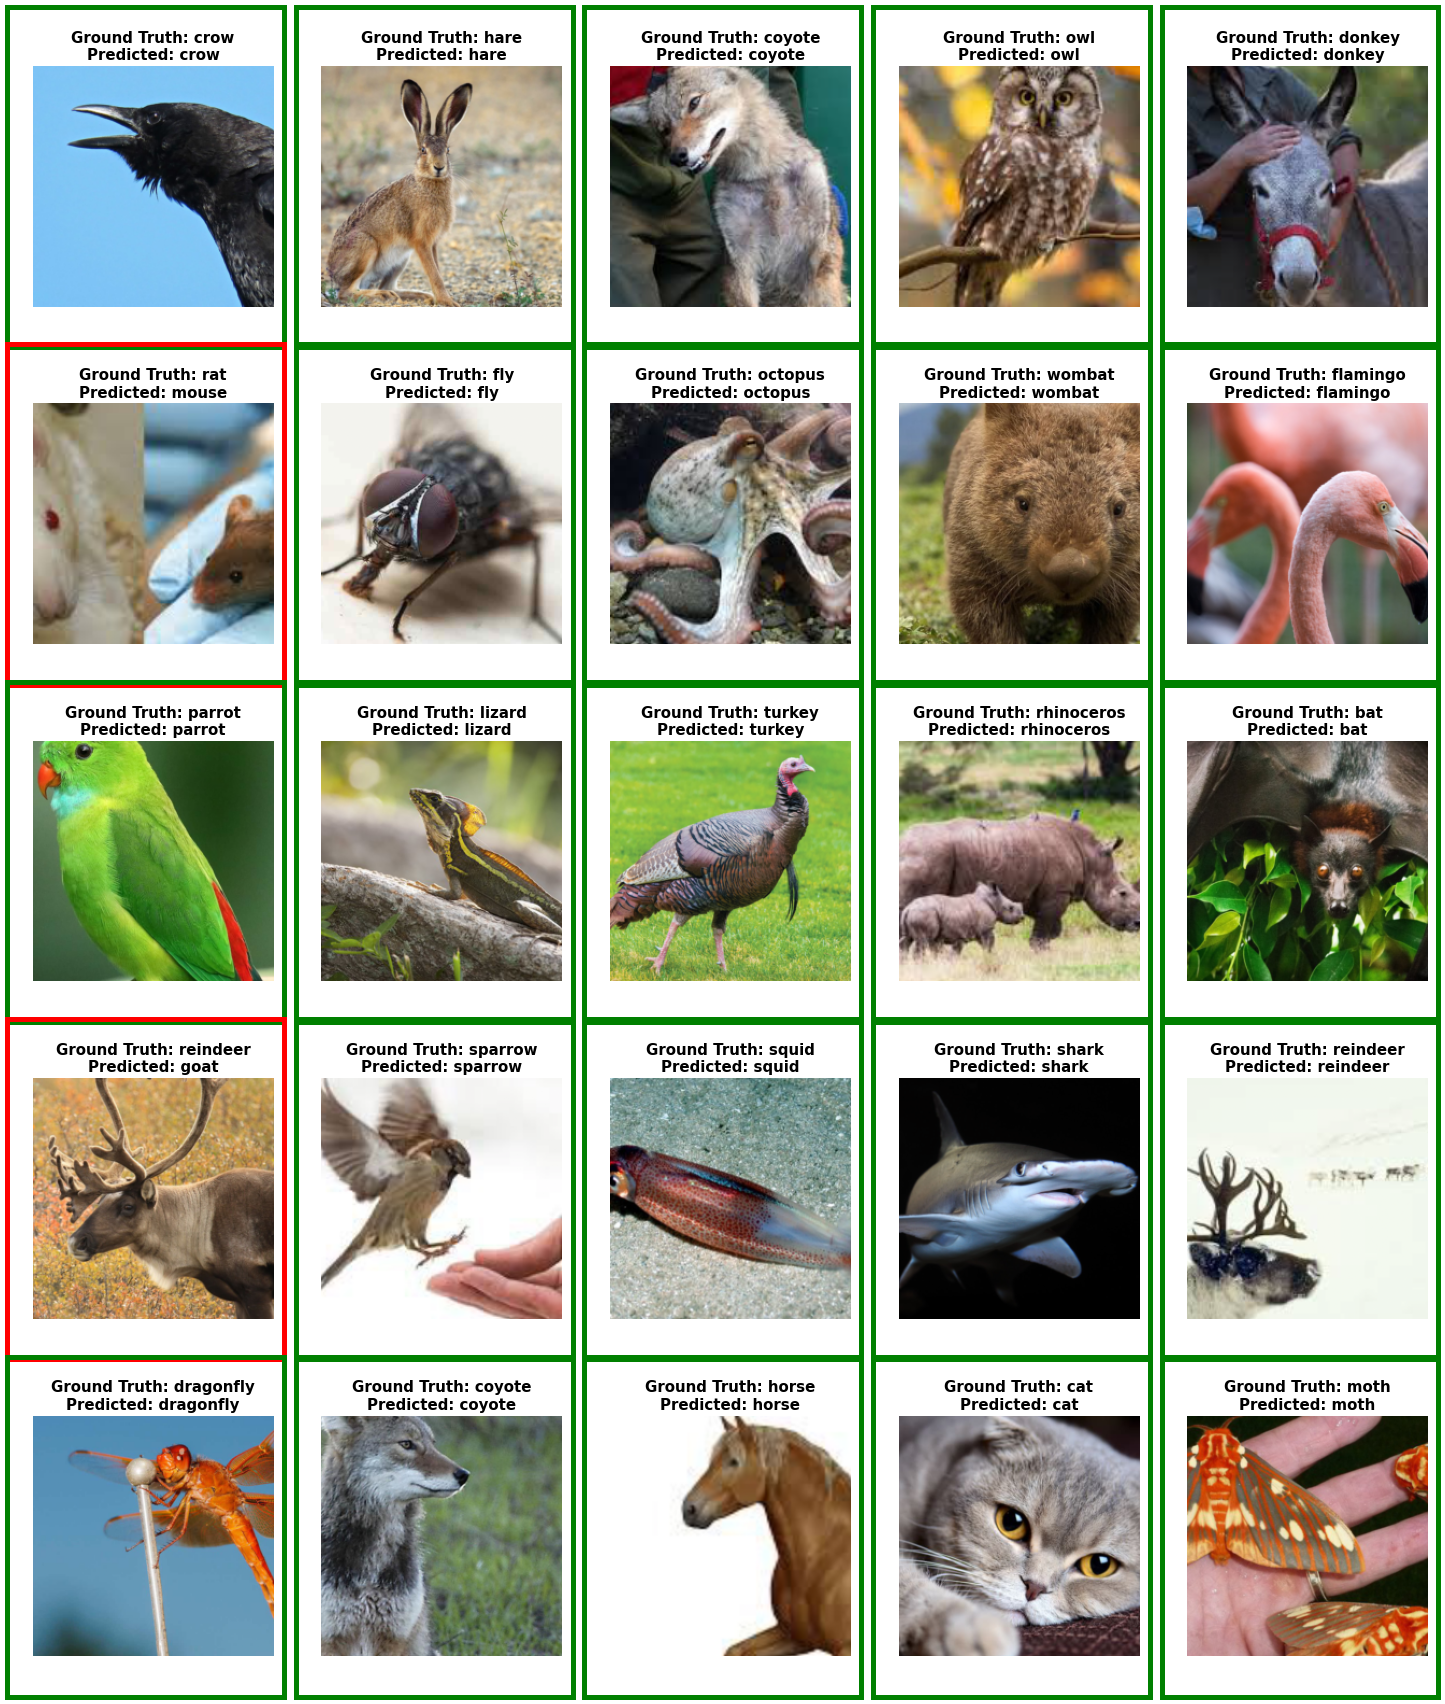

In [34]:
# Visualise on validation dataset
visualize_model(model_ft, val_loader)

From the first 30 images, it is pretty understandable where the model gets wrong.

Mouse and rat are literally the same animal, Darwin made a mistake there.

Reindeer's antlers may have been mistaken for goat's horns.

### Test Set

In [57]:
labels_list = []
preds_list = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels_list.extend(label.item() for label in labels)
        
        outputs = model_ft(inputs)
        
        predictions = torch.argmax(outputs, dim=1)
    
        preds_list.extend(prediction.item() for prediction in predictions)

        
count = 0
for i in range(len(preds_list)):
    if preds_list[i] == labels_list[i]:
        count += 1

accuracy = count / len(preds_list)
print(f'Test accuracy = {accuracy:.4f}')

  0%|          | 0/12 [00:00<?, ?it/s]

Test accuracy = 0.9250


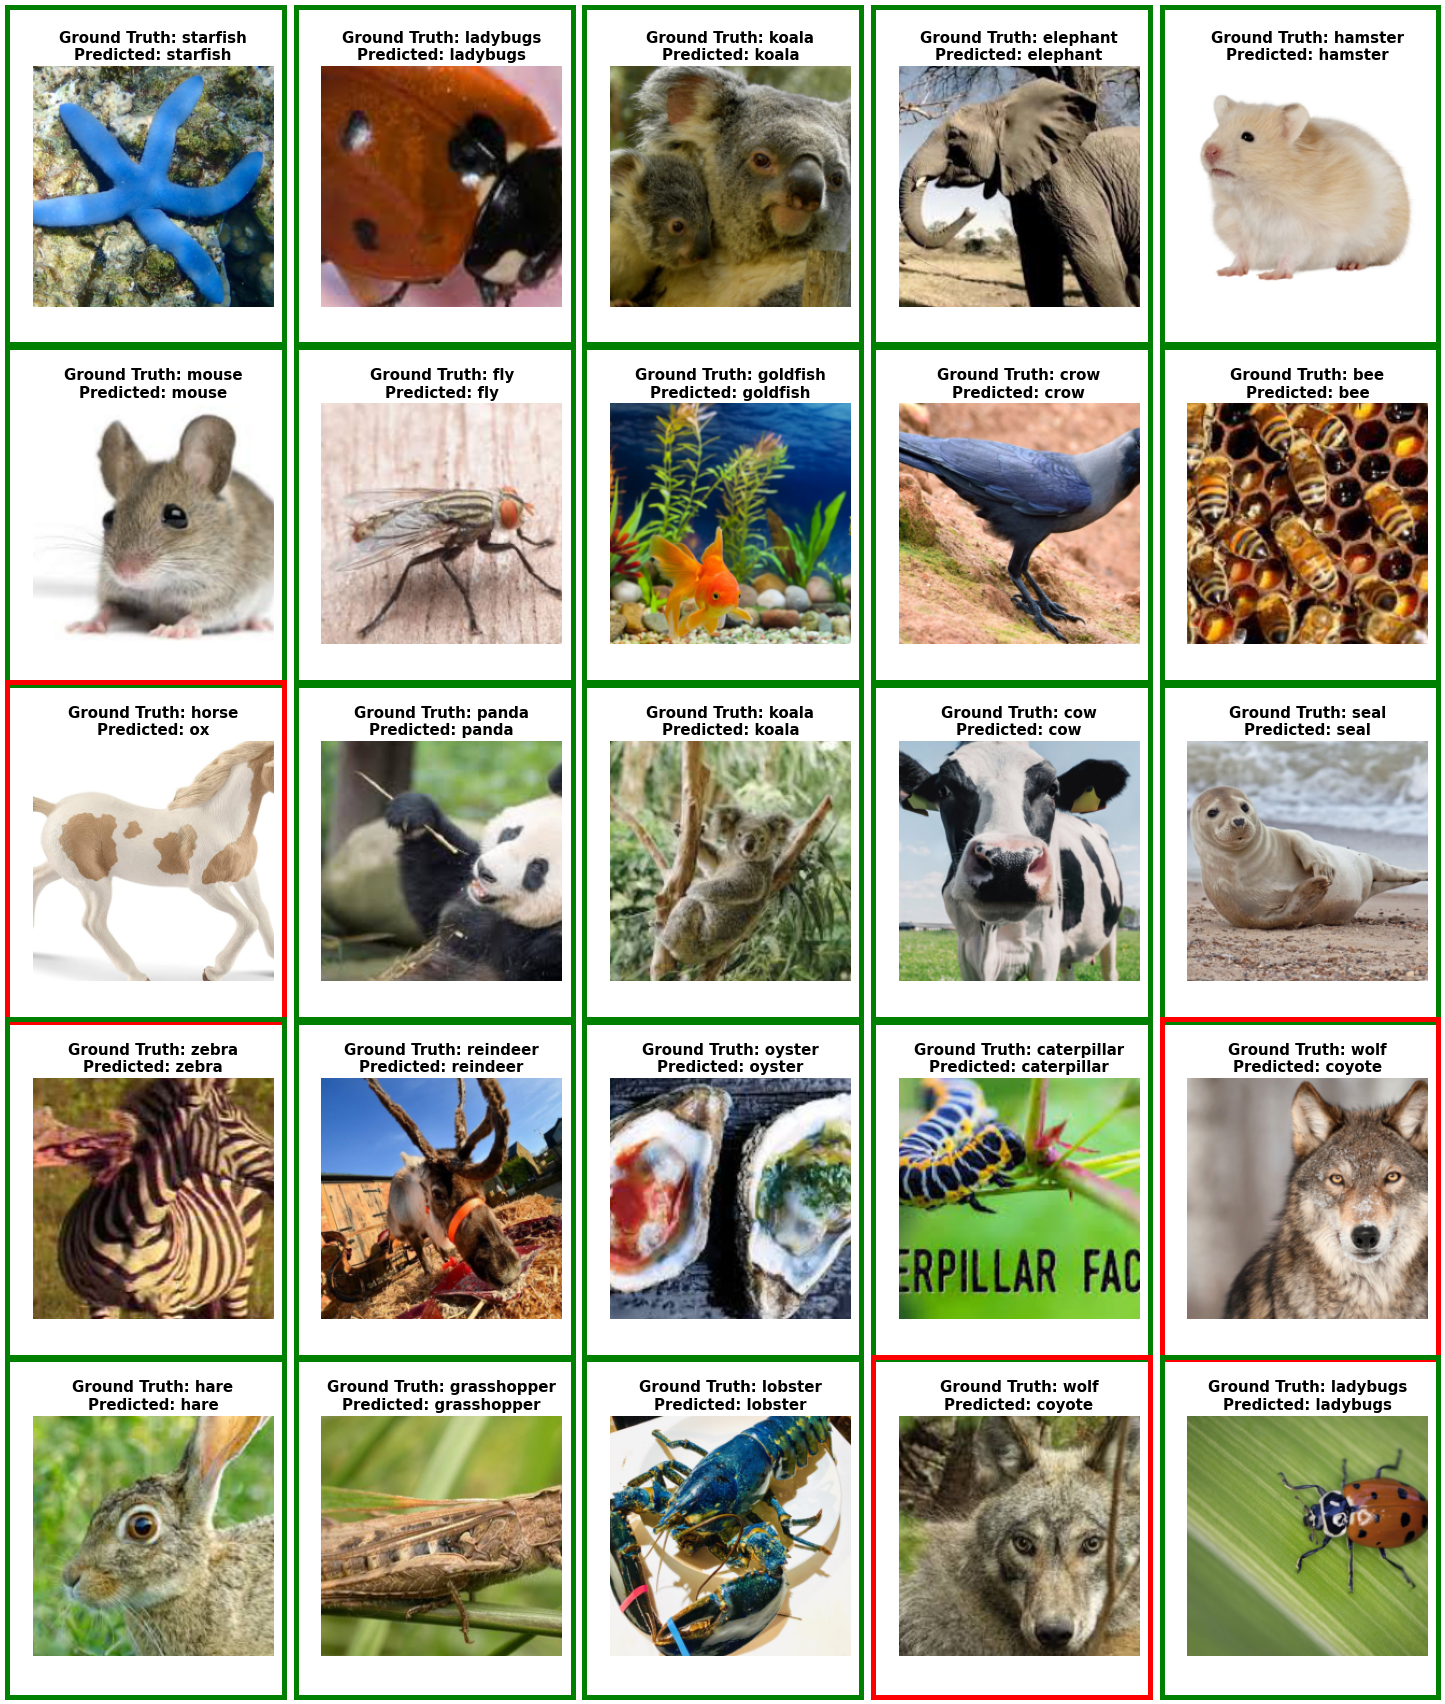

In [58]:
# Visualise predictions on test dataset
visualize_model(model_ft, test_loader)

In [79]:
from sklearn.metrics import classification_report

report = classification_report(labels_list, preds_list)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       0.67      1.00      0.80         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      0.75      0.86         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      0.75      0.86         4
          13       1.00      1.00      1.00         4
          14       0.50      0.75      0.60         4
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         4
          17       0.60    

Overall quite surprising that the model can perform well given:
1. Lack of data (60 images for each of the 90 classes) 
2. Similarity of different labels (whale vs shark, coyote vs wolf, rat vs mouse, antelope vs goat vs reindeer)

## Predict single images

Lets play around abit

In [93]:
from PIL import Image
import requests

def predict(model, url):
    
    tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    plt.figure(figsize=(5,5))
    
    image = Image.open(requests.get(url, stream=True).raw)
    img_tensor = tfms(image).to('cuda').unsqueeze(0)
    output = model(img_tensor)
    prediction = torch.argmax(output, dim=1)
    prediction = le.inverse_transform(prediction.cpu())

    
    plt.imshow(image)
    plt.title(f'Prediction: {prediction[0]}', fontsize="15")
        
    plt.axis('off')

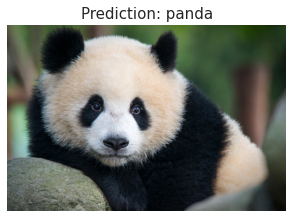

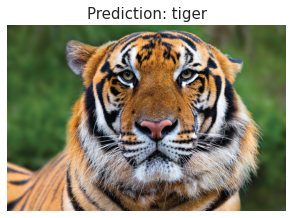

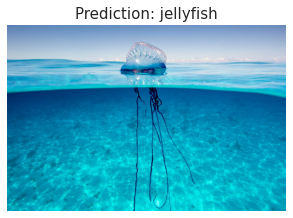

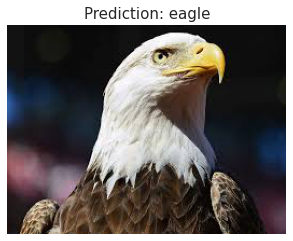

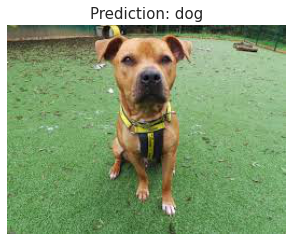

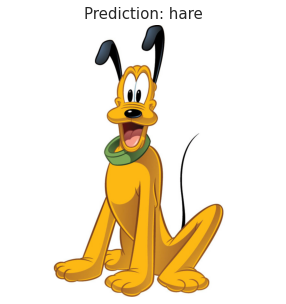

In [121]:
# Insert image address for single image prediction
url_list = [
    "https://static.scientificamerican.com/sciam/cache/file/ACF0A7DC-14E3-4263-93F438F6DA8CE98A_source.jpg?w=590&h=800&896FA922-DF63-4289-86E2E0A5A8D76BE1",
    "https://static.scientificamerican.com/sciam/cache/file/5C51E427-1715-44E6-9B14D9487D7B7F2D_source.jpg",
    "https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F521433364%2F0x0.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRUu8hCQUvHGXVZ79cQW_WFc9Adzsp-X0jqA&usqp=CAU",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRrtoRmgkcDwR7QUu0Nvpqi7h7geW6pMD5zqw&usqp=CAU",
    "https://static.wikia.nocookie.net/characters/images/a/ac/DSNY-SM-13.jpg/revision/latest?cb=20141231230015"
]

for url in url_list:
    predict(model_ft, url)

#### Predict animals that model have not been trained on

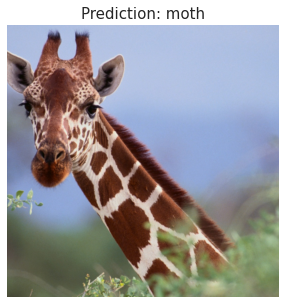

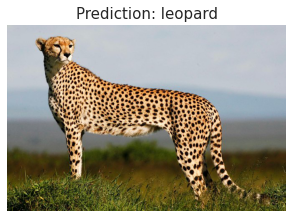

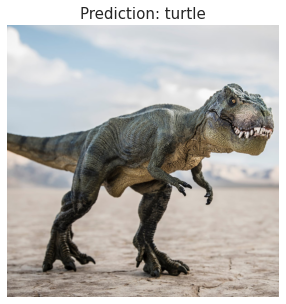

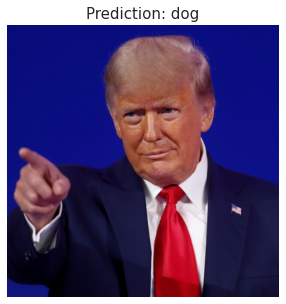

In [122]:
untrained_url_list = [
    "https://images.ctfassets.net/81iqaqpfd8fy/3r4flvP8Z26WmkMwAEWEco/870554ed7577541c5f3bc04942a47b95/78745131.jpg?w=1200&h=1200&fm=jpg&fit=fill",
    "https://media.tacdn.com/media/attractions-splice-spp-674x446/06/6c/2e/d4.jpg",
    "https://i.guim.co.uk/img/media/5dab212de07d8009dd06560efeb1ac87b114e23d/0_640_4183_2510/master/4183.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=7c9461c31fb8530f24343e669d6730ba",
    "https://images.wsj.net/im-307680?width=1280&size=1"
]

for url in untrained_url_list:
    predict(model_ft, url)